# Condiciones de aceptabilidad de modelos con polítropa I
## Espacio de parámetros

Este cuaderno muestra gráficamente el espacio de parámetros ($n,\ C,\ \sigma$), en función del número de condiciones de aceptabilidad cumplidas, para esferas anisótropas relativistas con ecuación de estado polítropa I
\begin{equation}
    P = \kappa \hat{\rho}^{1+\frac{1}{n}}
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import math
from scipy import integrate
from numpy import diff
from scipy.integrate import solve_ivp

In [2]:
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{amssymb}']}   # amssymb
plt.rcParams.update(params)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Modelado de objetos compactos

## Ecuaciones de estructura

Las ecuaciones de estructura son el resultado de manipular las ecuaciones de campo de Einstein para una métrica y un tensor de energía dado, y son las ecuaciones que hay que resolver para modelar objetos compactos. En el caso de configuraciones estáticas con simetría esférica y anisotropía en la presión, las ecuaciones de estructura consisten en

\begin{eqnarray}
P^{\prime} &=& - \left(\rho + P \right) \frac{m + 4 \pi r^{3} P}{r(r - 2m)} + \frac{2}{r} \left(P_{\perp} - P \right)  \label{EqHid} \tag{1} \\
m^{\prime} &=& 4 \pi r^{2} \rho \label{MasDif} \tag{2}
\end{eqnarray}
donde $\rho$ es densidad de energía, $m$ es masa, $P$ es presión radial, $P_{\perp}$ es presión tangencial y la prima denota derivada respecto a $r$.

## Ecuación de Estado

Una ecuación de estado (EoS por sus siglas en inglés) es un modelo matemático, entre variables de estado, que describe los procesos físicos más importantes que ocurren en un sistema termodinámico.

La EoS polítropa I consiste en una relación tal que
\begin{equation}
P = \kappa \hat{\rho}^{1+\frac{1}{n}}\,, \label{PoliI} \tag{3}
\end{equation}
donde $\hat{\rho}$ es densidad de masa bariónica.

Por otra parte, se supone que la anisotropía en a presión es de la forma
\begin{equation}
\Delta\equiv P_{\perp} - P = C r (\rho + P) \frac{m + 4 \pi r^3 P}{r(r-2m)} \,, \label{Anisotropia} \tag{4}
\end{equation}
tal que la ecuación (1) queda como
\begin{equation}
\frac{\mathrm{d}P}{\mathrm{d}r} = - h \frac{(\rho + P)(m + 4 \pi  r^3 P)}{r(r-2m)} \,, \label{EqHidCos} \tag{5}
\end{equation}
donde $h = 1 - 2C$, y $C$ cuantifica la anisotropía en el modelo.

## Ecuación de Lane-Emden

Las ecuaciones de estructura pueden escribirse de forma adimensional cuando son dotadas de EoS polítropas. El resultado es conocido como ecuación de Lane-Emden, dada por el cambio de variables
\begin{equation}
\hat{\psi}^{n} \left(\xi \right) = \frac{\hat{\rho}}{\hat{\rho}_{c}} \ , \ \ \eta \left(\xi \right) = \frac{m}{4 \pi \rho_c a^{3}} \quad \textrm{y} \quad r = a\xi \,,
\end{equation}
donde
\begin{equation}
a^{2} = \frac{\sigma \left(n + 1 \right)}{4 \pi \rho_c} \quad \textrm{y} \quad \sigma = \frac{P_{c}}{\rho_{c}}  \,.
\end{equation}
El subíndice $c$ indica que la variable es evaluada en el centro de la configuración.

De esta manera, las EoS $\eqref{PoliI}$ y $\eqref{Anisotropia}$ adimensionales son
\begin{eqnarray}
P &=& \kappa \hat{\rho}_{c}^{1 + \frac{1}{n}} \hat{\psi}^{n+1} = \Sigma \hat{\rho}_{c} \hat{\psi}^{n+1} \quad \textrm{y} \label{PAdi} \tag{6} \\
\Delta &=& \frac{C \left(n+1 \right) \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1}  \right)}{\xi - 2 \sigma \left(n+1 \right) \eta} \left\{\left(1 - \sigma n \right) \hat{\psi}^{n} + \sigma n \hat{\psi}^{n+1} + \sigma \hat{\psi}^{n+1} \right\} P_{c} \,, \label{AniAdi} \tag{7}
\end{eqnarray}
respectivamente. De donde es claro que $\Sigma = \kappa \hat{\rho}_{c}^{1/n} = P_{c}/ \hat{\rho}_{c} $ , y está relacionado con $\sigma$ a través de
\begin{equation*}
    \Sigma = \frac{\sigma}{1 - \sigma n} \,.  
\end{equation*}


Finalmente, las ecuaciones $\eqref{EqHidCos}$ y $\eqref{MasDif}$, escritas en su forma adimensional, son
\begin{eqnarray}
\dot{\hat{\psi}} &=& - \frac{h \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1} \right) \left\{\left(1 - \sigma n \right) + \sigma \left(n+1 \right) \hat{\psi} \right\}}{\xi \left\{\xi - 2 \sigma \left(n+1 \right) \eta \right\}} \qquad \textrm{y} \label{PsiPunto} \tag{8}  \\
\dot{\eta} &=& \xi^{2} \hat{\psi}^{n} \left(1 - \sigma n  + \sigma n \hat{\psi} \right) \label{EtaPunto} \tag{9}  \,,
\end{eqnarray}
donde el punto indica derivada respecto de $\xi$.

Por lo tanto, el sistema de ecuaciones a integrar numéricamente está dado por $\eqref{PsiPunto}$ y $\eqref{EtaPunto}$, con condiciones iniciales
\begin{equation}
\hat{\psi} (\xi = 0) = \hat{\psi}_{c} = 1 \,, \quad \eta (\xi = 0) = \eta_{c} = 0  \,,
\end{equation}
y con condición de frontera
\begin{equation}
\hat{\psi}(\xi = \xi_{b}) = 0 \,.
\end{equation}

In [3]:
# Definiendo sistema de ecuaciones: derivada de Psi y derivada de Eta en función de xi
def funciones(xi,y, sigma, n, h):
    psi_,eta_ = y
    dydxi = [-h*(eta_ + sigma*xi**(3)*psi_**(n+1))*((1 - n*sigma) + (n+1)*sigma*psi_)/xi/(xi - 2*sigma*(n+1)*eta_)
             ,xi**(2)*psi_**(n)*(1 - n*sigma + n*sigma*psi_)]
    return dydxi

In [4]:
# Se definen los parámetros (de entrada) que caracterizan a cada modelo: n, C, alpha, varkappa, sigma

Lista_n = [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0]        # Lista de índices polítropos n
print('Valores de n: ',end='')                                                    
print(*Lista_n, sep=', ')

Lista_C = [0,1/32,1/16,3/32,1/8,5/32,3/16,7/32,1/4]   # Lista de valores para el factor de anisotropía C
print('Valores de C: ',end='')
print(*Lista_C, sep=', ')
   
# Lista de sigmas    
Lista_sigma = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
print('Valores de \u03c3: ',end='')
print(*Lista_sigma, sep=', ')

# Número total de modelos evaluados
Numero_de_modelos = len(Lista_n)*len(Lista_C)*len(Lista_sigma)
print('Número de modelos: ', Numero_de_modelos)

Valores de n: 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0
Valores de C: 0, 0.03125, 0.0625, 0.09375, 0.125, 0.15625, 0.1875, 0.21875, 0.25
Valores de σ: 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8
Número de modelos:  1152


In [5]:
%%time

ListaModelos = []                                        # Contenedor para todos los modelos

contador = 0

for i in range(len(Lista_C)):
    
    ListaModelos.append([])                              # Contenedor para C
    
    C = Lista_C[i]
    h = 1 - 2*C
    
    for j in range(len(Lista_n)):
        
        ListaModelos[i].append([])                       # Contenedor para n
        n = Lista_n[j]
        
        for k in range(len(Lista_sigma)):
            
            ListaModelos[i][j].append([])                # Contenedor para sigma
            
            sigma = Lista_sigma[k]
                                     
            # Condiciones iniciales
            Psi0 = 1.0
            Eta0 = 0.0
            y0 = [Psi0,Eta0]
            
            # Intervalo de integración
            xi0 = 10**(-15) # Inicio
            ximax = 10000   # Fin, en caso de que la condición para detener la integración no se cumpla
            xi_span = (xi0,ximax) # Espacio de integración
            
            # Condición para detener la integración (Presión adimensional menor que 10**(-15))
            def stop_condition(xi,y,sigma,n,h):
                return y[0] - 10**(-15)
            stop_condition.terminal = True
            
            # Solución del sistema de ecuaciones utilizando la rutina "solve_ivp" por medio del método RK45
            # solve_ivp(Ecuaciones a integrar, Espacio de integración, Condiciones iniciales, Método de integración,
            #           Condición para detener la integración)
            soluciones = solve_ivp(funciones,xi_span,y0,method='RK45',events=stop_condition,
                                   args=(sigma,n,h))
            
            if soluciones.status != 0:
                xi = soluciones.t
                Psi = soluciones.y[0]
                Eta = soluciones.y[1]
            else:
                ListaModelos[i][j][k] = ('gray','X',5),C,n,sigma
                print('Modelo sin borde. Parámetros: ',f'C = {C}, n = {n}, \u03c3 = {sigma}')
                contador = contador + 1
                continue
                
            # Derivada de Psi
            Psi1 = -h*(Eta + sigma*xi**(3)*Psi**(n+1))*((1 - n*sigma) + (n+1)*sigma*Psi)/xi/(xi - 2*sigma*(n+1)*Eta)
    
            # Derivada de Eta
            Eta1 = xi**(2)*Psi**(n)*(1 - n*sigma + n*sigma*Psi)
            
            # Xi normalizada
            xiNorm = xi/xi[-1]

        ### Condición C1

            compacidad = 2*sigma*(n+1)*Eta/xi
        
        ### Condición C2
            
            # Densidad de masa bariónica
            Densidad = Psi**(n) 
            
            #Densidad de energía
            DensidadEnergia = (1 - n*sigma)*Psi**(n) + n*sigma*Psi**(n+1)
            
            # Presión entre presión central
            PNorm = Psi**(n+1)
        
            # Presión tangencial
            PTNorm = (C*(n+1)*(Eta + sigma*Psi**(n+1)*xi**(3))/(xi - 2*Eta*sigma*(n+1)))*((1 - n*sigma)*Psi**(n) + (n+1)*sigma*Psi**(n+1)) + Psi**(n+1)
                
            C2 = [Densidad, PNorm, PTNorm]
        
        ### Condición C3
            
            # Gradiente de densidad de energía
            GradDenEner = n*Psi1*((1-sigma*n)*Psi**(n-1) + sigma*(n+1)*Psi**(n))
            
            # Gradiente de densidad de masa
            Dprima = n*Psi**(n-1)*Psi1     
          
            # Gradiente de presión radial
            Pprima = (n+1)*Psi**(n)*Psi1
            
            # Gradiente de presión tangencial
            Ptprima = C*(n+1)*((Eta1 + 3*sigma*xi**(2)*Psi**(n+1) + sigma*(n+1)*xi**(3)*Psi**(n)*Psi1)*((1-sigma*n)*Psi**(n) + sigma*(n+1)*Psi**(n+1))/(xi - 2*Eta*(n+1)*sigma) + (Eta + sigma*xi**(3)*Psi**(n+1))*(n*(1 - sigma*n)*Psi**(n-1)*Psi1 + sigma*(n+1)**(2)*Psi**(n)*Psi1)/(xi - 2*Eta*(n+1)*sigma) - (Eta + sigma*xi**(3)*Psi**(n+1))*((1 - sigma*n)*Psi**(n) + sigma*(n+1)*Psi**(n+1))*(1 - 2*Eta1*(n+1)*sigma)/(xi - 2*Eta*(n+1)*sigma)**(2)) + (n+1)*Psi**(n)*Psi1
            
            C3 = [GradDenEner,Pprima,Ptprima]
            
        ### Condición C4
        
            # Condición sobre la traza (TEC)
            TEC = (1/sigma)*DensidadEnergia - PNorm - 2*PTNorm 
            
        ### Condición C5
        
            # Velocidad del sonido radial al cuadrado
            v2r = ((n+1)/n)*(sigma*Psi)/(sigma*Psi*(n+1) + (1 - n*sigma))
            
            aux1 = 1 - sigma*n + sigma*(n+1)*Psi   # Variable auxiliar
        
            # Diferencia de las velocidades del sonido al cuadrado
            vDelta2 = (C*sigma*(n+1)/(xi-2*sigma*(n+1)*Eta))*((1 + sigma*(n+1)*Psi/n/aux1)*(Eta + sigma*xi**(3)*Psi**(n+1)) + Psi**(n)*aux1*(xi**(2)*Psi*(1 - sigma*n + sigma*(n+3)*Psi + sigma*(n+1)*xi*Psi1)/n/aux1/Psi1) - Psi**(n)*aux1*(Eta + sigma*xi**(3)*Psi**(n+1))*(1 - 2*sigma*(n+1)*xi**(2)*Psi**(n)*(1 - sigma*n + sigma*n*Psi))/n/Psi1/((1-sigma*n)*Psi**(n-1) + sigma*(n+1)*Psi**(n))/(xi - 2*sigma*(n+1)*Eta))
            
            # Velocidad del sonido tangencial al cuadrado
            v2t = vDelta2 + v2r
            
            C5 = [v2r, v2t]
            
        ### Condición C6
            
            # Índice adiabático Gamma
            Gamma = v2r*(DensidadEnergia + sigma*PNorm)/PNorm/sigma
            
        ### Condición C8
        
            # Segunda derivada de Psi
            Psi11 = h*(((Eta1 + 3*sigma*xi**(2)*Psi**(n+1) + sigma*xi**(3)*(n+1)*Psi**(n)*Psi1)*((1 - n*sigma) + (n+1)*sigma*Psi)/xi/(2*(n+1)*sigma*Eta - xi)) + (sigma*(n+1)*Psi1)*(Eta + sigma*xi**(3)*Psi**(n+1))/xi/(2*(n+1)*sigma*Eta - xi) - (((1 - n*sigma) + (n+1)*sigma*Psi)*(Eta + sigma*xi**(3)*Psi**(n+1))/xi**(2)/(2*(n+1)*sigma*Eta - xi))     -     (((1 - n*sigma) + (n+1)*sigma*Psi)*(Eta + sigma*xi**(3)*Psi**(n+1))*(2*(n+1)*sigma*Eta1 - 1)/xi/((2*(n+1)*sigma*Eta - xi)**(2))))
                    
            # Fracturas: deltaR1: Densidad, deltaR2: Masa, deltaR3: Presión, delta R4: Gradiente de presión   
            deltaR1 = h*((n+1)*sigma*(Eta + xi**(3)*sigma*Psi**(n+1))/xi/(xi - 2*sigma*n*Eta - 2*sigma* Eta))
            deltaR2 = h*(((1 - n*sigma)*Psi**(n) + (n+1)*sigma*Psi**(n+1))*(1 + 2*xi**(2)*sigma**(2)*(n+1)*Psi**(n+1))/(xi - 2*sigma*(n+1)*Eta)**(2))*(xi**(2)*sigma*(n+1)*((1 - n*sigma)*Psi**(n) + n*sigma*Psi**(n+1))/((1 - n*sigma)*n*Psi**(n-1)*Psi1 + n*sigma*(n+1)*Psi**(n)*Psi1))
            deltaR3 = h*(sigma*(n+1)*(Eta + xi**(3)*(1 - n*sigma)*Psi**(n) + xi**(3)*sigma*(n+2)*Psi**(n+1))/xi/(xi - 2*sigma*(n+1)*Eta))*(1 + 1/n)*(sigma*Psi/(sigma*Psi*(n+1) + (1 - n*sigma)))
            deltaR4 = sigma*(n+1)*(Psi**(n)*Psi11 + n*Psi**(n-1)*Psi1**(2))/((1 - n*sigma)*n*Psi**(n-1)*Psi1 + n*sigma*(n+1)*Psi**(n)*Psi1)
            
            deltaRPolitropa = deltaR1 + deltaR2 + deltaR3 + deltaR4
                        
        ### Condición C9
            
            # Flotabilidad
            Psin11 = (n*(1 - n*sigma))*(Psi**(n-1)*Psi11 + (n-1)*Psi**(n-2)*Psi1**(2)) + (n*sigma*(n+1))*(Psi**(n)*Psi11 + n*Psi**(n-1)*Psi1**(2))
                         
######################################################################################################################
            
            # C1
            
            if any(compacidad >= 1):
                ListaModelos[i][j][k].append(_)
            else:
                pass
            
            # C2
            
            if any(Densidad < 0) or any(PNorm < 0) or any(PTNorm < 0):
                ListaModelos[i][j][k].append(_)
            else:
                pass
            
            # C3
            
            if any(GradDenEner > 0) or any (Pprima > 0) or any (Ptprima[10:] > 0):
                ListaModelos[i][j][k].append(_)
            else:
                pass
            

            # C4
            
            if any(TEC < 0):
                ListaModelos[i][j][k].append(_)
            else:
                pass
            
            # C5
            
            if any(v2r > 1) or any(v2t > 1):
                ListaModelos[i][j][k].append(_)
            else:
                pass
            
            # C6
            
            if any(Gamma < 4/3):
                ListaModelos[i][j][k].append(_)
            else:
                pass
            
            # C7                        
            
            if n == 1.0 :
                
                if C == 1/4 and (sigma >= 0.25 or sigma <= 0.325) :
                    ListaModelos[i][j][k].append(_)
                else:
                    pass
                    
            
            elif n == 1.5 :
                
                if C == 7/32  and (sigma >= 0.125 or sigma <= 0.225) :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 1/4 and (sigma >= 0.1 or sigma <= 0.25) :
                    ListaModelos[i][j][k].append(_)
                
                else:
                    pass
                    
            
            elif n == 2.0 :
                    
                if C == 1/8 and (sigma >= 0.1 or sigma <= 0.15) :
                    ListaModelos[i][j][k].append(_)
                    
                elif C == 5/32 and sigma <= 0.15 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 3/16 and sigma <= 0.175 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 7/32  and sigma <= 0.175 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 1/4 and sigma <= 0.175 :
                    ListaModelos[i][j][k].append(_)
                    
                else:
                    pass
                    
            
            elif n == 2.5 :
            
                if C == 0 and sigma <= 0.1 :
                    ListaModelos[i][j][k].append(_)
            
                elif C == 1/32 and sigma <= 0.1 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 1/16 and sigma <= 0.125 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 3/32 and sigma <= 0.125 :
                    ListaModelos[i][j][k].append(_)
                    
                elif C == 1/8 and sigma <= 0.125 :
                    ListaModelos[i][j][k].append(_)
                    
                elif C == 5/32 and sigma <= 0.125 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 3/16 and sigma <= 0.125 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 7/32  and sigma <= 0.125 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 1/4 and sigma <= 0.125 :
                    ListaModelos[i][j][k].append(_)
                    
                else:
                    pass
                    
            
            elif n == 3.0 :
            
                if C == 0 and sigma <= 0.1 :
                    ListaModelos[i][j][k].append(_)
            
                elif C == 1/32 and sigma <= 0.1 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 1/16 and sigma <= 0.1 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 3/32 and sigma <= 0.1 :
                    ListaModelos[i][j][k].append(_)
                    
                elif C == 1/8 and sigma <= 0.1 :
                    ListaModelos[i][j][k].append(_)
                    
                elif C == 5/32 and sigma <= 0.1 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 3/16 and sigma <= 0.1 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 7/32  and sigma <= 0.1 :
                    ListaModelos[i][j][k].append(_)
                
                elif C == 1/4 and sigma < 0.1 :
                    ListaModelos[i][j][k].append(_)
                    
                else:
                    pass
                
            elif n == 3.5 :
                ListaModelos[i][j][k].append(_)
            
            
            elif n == 4.0 :
                ListaModelos[i][j][k].append(_)
            
            else:
                pass
                    
            
            # C8
           
            if any(np.diff(np.sign(deltaRPolitropa[1:])) != 0):
                ListaModelos[i][j][k].append(_)
            else:
                pass

            # C9
            
            if any(Psin11 > 0):
                ListaModelos[i][j][k].append(_)
            else:
                pass  
                        
            ListaModelos[i][j][k] = (('red','o',5) if len(ListaModelos[i][j][k]) == 0
                                     else ('blue','o',5) if len(ListaModelos[i][j][k]) == 1
                                     else ('green','o',5) if len(ListaModelos[i][j][k]) == 2
                                     else ('darkorange','o',5) if len(ListaModelos[i][j][k]) == 3
                                     else ('purple','o',5) if len(ListaModelos[i][j][k]) == 4
                                     else ('white','o',0)),C,n,sigma

C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Modelo sin borde. Parámetros:  C = 0, n = 1.5, σ = 0.7
Modelo sin borde. Parámetros:  C = 0, n = 1.5, σ = 0.75
Modelo sin borde. Parámetros:  C = 0, n = 1.5, σ = 0.8
Modelo sin borde. Parámetros:  C = 0, n = 2.0, σ = 0.5
Modelo sin borde. Parámetros:  C = 0, n = 2.0, σ = 0.55
Modelo sin borde. Parámetros:  C = 0, n = 2.0, σ = 0.6
Modelo sin borde. Parámetros:  C = 0, n = 2.0, σ = 0.65
Modelo sin borde. Parámetros:  C = 0, n = 2.0, σ = 0.7
Modelo sin borde. Parámetros:  C = 0, n = 2.0, σ = 0.75
Modelo sin borde. Parámetros:  C = 0, n = 2.0, σ = 0.8
Modelo sin borde. Parámetros:  C = 0, n = 2.5, σ = 0.4
Modelo sin borde. Parámetros:  C = 0, n = 2.5, σ = 0.45
Modelo sin borde. Parámetros:  C = 0, n = 2.5, σ = 0.5
Modelo sin borde. Parámetros:  C = 0, n = 2.5, σ = 0.55
Modelo sin borde. Parámetros:  C = 0, n = 2.5, σ = 0.6
Modelo sin borde. Parámetros:  C = 0, n = 2.5, σ = 0.65
Modelo sin borde. Parámetros:  C = 0, n = 2.5, σ = 0.7
Modelo sin borde. Parámetros:  C = 0, n = 2.5, σ = 0.75
Mo

Modelo sin borde. Parámetros:  C = 0.0625, n = 3.5, σ = 0.4
Modelo sin borde. Parámetros:  C = 0.0625, n = 3.5, σ = 0.45
Modelo sin borde. Parámetros:  C = 0.0625, n = 3.5, σ = 0.5
Modelo sin borde. Parámetros:  C = 0.0625, n = 3.5, σ = 0.55
Modelo sin borde. Parámetros:  C = 0.0625, n = 3.5, σ = 0.6
Modelo sin borde. Parámetros:  C = 0.0625, n = 3.5, σ = 0.65
Modelo sin borde. Parámetros:  C = 0.0625, n = 3.5, σ = 0.7
Modelo sin borde. Parámetros:  C = 0.0625, n = 3.5, σ = 0.75
Modelo sin borde. Parámetros:  C = 0.0625, n = 3.5, σ = 0.8
Modelo sin borde. Parámetros:  C = 0.0625, n = 4.0, σ = 0.1
Modelo sin borde. Parámetros:  C = 0.0625, n = 4.0, σ = 0.15
Modelo sin borde. Parámetros:  C = 0.0625, n = 4.0, σ = 0.2
Modelo sin borde. Parámetros:  C = 0.0625, n = 4.0, σ = 0.25
Modelo sin borde. Parámetros:  C = 0.0625, n = 4.0, σ = 0.3
Modelo sin borde. Parámetros:  C = 0.0625, n = 4.0, σ = 0.35
Modelo sin borde. Parámetros:  C = 0.0625, n = 4.0, σ = 0.4
Modelo sin borde. Parámetros:  C 

Modelo sin borde. Parámetros:  C = 0.15625, n = 1.5, σ = 0.7
Modelo sin borde. Parámetros:  C = 0.15625, n = 1.5, σ = 0.75
Modelo sin borde. Parámetros:  C = 0.15625, n = 1.5, σ = 0.8
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.0, σ = 0.5
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.0, σ = 0.55
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.0, σ = 0.6
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.0, σ = 0.65
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.0, σ = 0.7
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.0, σ = 0.75
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.0, σ = 0.8
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.5, σ = 0.4
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.5, σ = 0.45
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.5, σ = 0.5
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.5, σ = 0.55
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.5, σ = 0.6
Modelo sin borde. Parámetros:  C = 0.15625, n = 2.5, σ = 0.65
Modelo sin borde.

Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.2
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.25
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.3
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.35
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.4
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.45
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.5
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.55
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.6
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.65
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.7
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.75
Modelo sin borde. Parámetros:  C = 0.21875, n = 3.5, σ = 0.8
Modelo sin borde. Parámetros:  C = 0.21875, n = 4.0, σ = 0.1
Modelo sin borde. Parámetros:  C = 0.21875, n = 4.0, σ = 0.15
Modelo sin borde. Parámetros:  C = 0.21875, n = 4.0, σ = 0.2
Modelo sin borde.

In [6]:
print(contador, ' de ', Numero_de_modelos, ' NO tienen borde')

515  de  1152  NO tienen borde


## * Condición C1: $\, \, \frac{2m}{r} < 1$

La compacidad $\mu$ está dada por
\begin{equation}
    \mu = \frac{2m}{r} \equiv \frac{2 \sigma \left(n+1 \right) \eta}{\xi}
\end{equation}

## * Condición C2: $\,\, \rho \geq 0$, $\,\,P \geq 0$, $\,\,P_{\perp} \geq 0$

La densidad de energía, presión radial y presión tangencial adimensionales son:
\begin{eqnarray}
     \frac{\rho}{\rho_{c}} &=& \left(1 - \sigma n \right) \hat{\psi}^{n} + \sigma n \hat{\psi}^{n+1} \,, \\
     \frac{P}{P_{c}} &=& \hat{\psi}^{n+1} \qquad \textrm{y} \\
     \frac{P_{\perp}}{P_{c}} &=& \frac{C \left(n+1 \right) \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1}  \right)}{\xi - 2 \sigma \left(n+1 \right) \eta} \left\{\left(1 - \sigma n \right) \hat{\psi}^{n} + \sigma (n+1) \hat{\psi}^{n+1} \right\} + \hat{\psi}^{n+1} \,,
\end{eqnarray}
respectivamente.

## * Condición C3: $\,\, \rho^{\prime} \leq 0$, $\,\,P^{\prime} \leq 0$, $\,\,P^{\prime}_{\perp} \leq 0$

Los gradientes de energía, de presión radial y de presión tangencial adimensionales son:
\begin{eqnarray}
    \frac{\dot{\rho}}{\rho_{c}} &=& n \left\{\left(1-\sigma n \right) \hat{\psi}^{n-1} + \sigma \left(n+1\right)\hat{\psi}^{n}\right\} \dot{\hat{\psi}} \,, \\
    \frac{\dot{P}}{P_{c}} &=& \left(n+1 \right) \hat{\psi}^{n} \dot{\hat{\psi}} \qquad \textrm{y} \\
    \frac{\dot{P}_{\perp}}{P_{c}} &=& \frac{C \sigma \left(n+1\right)}{\xi - 2\sigma\left(n+1\right)\eta} \Bigg\{ \hat{\psi}^{n-1} \dot{\hat{\psi}} \left\{n\left(1-\sigma n\right) + \sigma\left(n+1\right)^{2} \hat{\psi} \right\} \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1} \right)\Bigg.\nonumber \\
    && + \; \xi^{2} \hat{\psi}^{2n} \left\{1 - \sigma n + \sigma \left(n+1\right) \hat{\psi} \right\} \left\{1 - \sigma n + \sigma\left(n+3\right) \hat{\psi} + \sigma\left(n+1\right) \xi \dot{\hat{\psi}} \right\} \nonumber \\
     &&  - \; \Bigg. \frac{\hat{\psi}^{n} \left\{1 - \sigma n + \sigma \left(n+1\right) \hat{\psi}\right\} \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1} \right) \left\{1 - 2\sigma\left(n+1\right) \dot{\eta} \right\}}{\xi - 2\sigma\left(n+1\right)\eta}  \Bigg\} + \left(n+1 \right) \hat{\psi}^{n} \dot{\hat{\psi}} 
\end{eqnarray}
respectivamente.

## * Condición C4: $\,\, \rho - P - 2 P_{\perp} \geq 0$

La condición sobre la traza del tensor energía-momento es
\begin{equation}
    \left\{\left(1/\sigma \right) - n \right\} \hat{\psi}^{n} + n \hat{\psi}^{n+1} - 3 \hat{\psi}^{n+1} - \frac{2C(n+1)\left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1} \right)}{\xi - 2 \sigma (n+1) \eta} \left\{(1 - \sigma n) \hat{\psi}^{n} + \sigma (n+1) \hat{\psi}^{n+1} \right\} 
\end{equation}

## * Condición C5: $\,\, 0 < v_{s}^{2} \leq 1 \,\, $ y $\,\,0 < v_{s \perp}^{2} \leq 1$

Las velocidades del sonido radial y tangencial, adimensionales, son
\begin{eqnarray}
    v^{2}_{s} &=& \frac{\sigma \left(n+1\right) \hat{\psi}}{n\left\{1 - \sigma n + \sigma (n+1) \hat{\psi} \right\}} \qquad \textrm{y} \\
    v^{2}_{s \perp} &=& \frac{C \sigma\left(n+1\right)}{\xi -2\sigma\left(n+1\right)\eta} \Bigg\{ \left(1 + v^{2}_{s} \right) \left( \eta + \sigma \xi^{3}\hat{\psi}^{n+1} \right) + \frac{\xi^{2} \hat{\psi}^{n+1} \left\{1 - \sigma n + \sigma \left(n+3\right) \hat{\psi} + \sigma \left(n+1\right) \xi \dot{\hat{\psi}} \right\}}{n \dot{\hat{\psi}}} - \left. \frac{\hat{\psi} \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1} \right) \left\{ 1 - 2 \sigma \left(n+1\right) \xi^{2} \hat{\psi}^{n} \left(1 - \sigma n + \sigma n \hat{\psi}\right) \right\}}{n \dot{\hat{\psi}} \left\{\xi - 2 \sigma \left(n+1\right) \eta \right\}} \right\} + v^{2}_{s} \,,
\end{eqnarray}
respectivamente.

## * Condición C6: $\,\, \Gamma \leq \frac{4}{3}$

El índice adiabático es
\begin{equation}
    \Gamma \equiv \frac{n+1}{n}
\end{equation}

## * Condición C7: $\,\, \frac{\mathrm{d}M(\rho_{c})}{\mathrm{d}\rho_{c}} > 0$

Esta condición requiere de la variación del parámetro $\sigma$, por lo tanto se ha realizado aparte en [Condición C7](https://github.com/danielfsu/TrabajoDeInvestigacion/blob/main/Pol%C3%ADtropa_I_%28Densidad_de_Masa%29/Pol%C3%ADtropa%20I%20-%20C7.ipynb).

## * Condición C8: Cambio de signo en la ecuación de equilibrio perturbada

La ecuación de equilibrio perturbada está dada por
\begin{equation}
    \frac{\delta \mathcal{R}}{\delta \rho} = \underbrace{\frac{h \left(m + 4 \pi r^{3} P \right)}{r(r-2m)}}_{\mathcal{R}_{1}}  + \underbrace{\frac{h \left(\rho + P \right) \left(1 + 8 \pi P r^{2} \right)}{\left(r - 2m \right)^{2}} \, \frac{4 \pi r^{2} \rho}{\rho^{\prime}}}_{\mathcal{R}_{2}} + \underbrace{\frac{h \left\{m + 4 \pi r^{3} \left(\rho + 2 P \right) \right\}}{r(r-2m)} v^{2}}_{\mathcal{R}_{3}}  + \underbrace{\left\{\left(v^{2} \right)^{\prime} + v^{2} \frac{\rho^{\prime \prime}}{\rho^{\prime}} \right\}}_{\mathcal{R}_{4}} \,,
\end{equation}
donde
\begin{equation}
    \mathcal{R} = \frac{\mathrm{d}P}{\mathrm{d}r} + h \frac{(\rho + P)(m + 4 \pi  r^3 P)}{r(r-2m)} = 0 \,.
\end{equation}

Por lo tanto, la ecuación de equilibrio hidrostático perturbada adimensional es
\begin{eqnarray}
a \frac{\delta \mathcal{R}}{\delta \rho} &\equiv& \frac{h \sigma \left(n+1 \right) \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1}\right)}{\xi \left\{\xi - 2 \sigma\left(n+1 \right) \eta \right\}} + \frac{h\left\{ \left(1 - n \sigma \right) \hat{\psi}^{n} + \sigma \left( n+1 \right) \hat{\psi}^{n+1} \right\} \left\{1 + 2 \sigma^{2} \xi^{2}(n+1) \hat{\psi}^{n+1} \right\}}{ \left\{\xi - 2 \sigma\left(n+1 \right) \eta \right\}^{2}} \times \frac{\sigma \xi^{2} \left( n+1 \right) \left\{ \left( 1 - \sigma n \right) \hat{\psi}^{n} + \sigma n  \hat{\psi}^{n+1} \right\}}{n \hat{\psi}^{n-1} \dot{\hat{\psi}} \left\{(1 - \sigma n) + \sigma (n+1) \hat{\psi} \right\} } \nonumber \\ && + \frac{h \sigma^{2} (n + 1)^{2} \hat{\psi} \left\{\eta + \xi^{3} \left( 1 - \sigma n \right)  \hat{\psi}^{n} + \sigma \xi^{3} \left( n+2 \right) \hat{\psi}^{n + 1}) \right\}}{n \xi \left\{\xi - 2 \sigma (n+1) \eta \right\} \left\{\left( 1 - n \sigma \right) + \sigma \left( n+1 \right) \hat{\psi} \right\}} + \frac{\sigma (n + 1) \left\{ \hat{\psi}^{n} \ddot{\hat{\psi}} + n \hat{\psi}^{n-1} \left(\dot{\hat{\psi}} \right)^{2} \right\}}{n \hat{\psi}^{n-1} \dot{\hat{\psi}} \left\{(1 - \sigma n) + \sigma (n+1) \hat{\psi} \right\}} =  \bar{\mathcal{R}}
\end{eqnarray}


## * Condición C9: $\,\, \rho^{\prime \prime} \leq 0$

La segunda derivada de la densidad de energía adimensional es
\begin{equation}
    \ddot{\left(\psi^{n}\right)} = n \left\{\left(n-1 \right) \hat{\psi}^{n-2} \left(\dot{\hat{\psi}} \right)^{2} + \hat{\psi}^{n-1} \ddot{\hat{\psi}} \right\}
\end{equation}

In [7]:
legend_elements = [Line2D([0],[0],marker='o',color='w',label='9',markerfacecolor='red',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='8',markerfacecolor='blue',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='7',markerfacecolor='green',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='6',markerfacecolor='darkorange',markersize=5),
                   Line2D([0],[0],marker='o',color='w',label='5',markerfacecolor='purple',markersize=5),
                   Line2D([0],[0],marker='X',color='w',label='Sin\ borde',markerfacecolor='gray',markersize=6.5)]

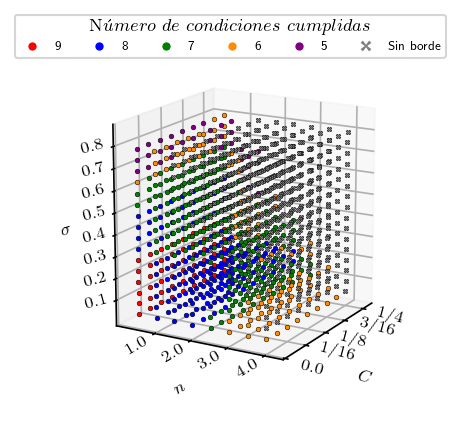

In [8]:
fig = plt.figure(figsize=(6,9),dpi=150)

ax1 = fig.add_subplot(321, projection='3d',zorder=3)

for i in range(len(Lista_C)):
        
    for j in range(len(Lista_n)):
                
        for k in range(len(Lista_sigma)):
            
            ax1.scatter(Lista_C[i],Lista_n[j],Lista_sigma[k],c=ListaModelos[i][j][k][0][0],marker=ListaModelos[i][j][k][0][1],
                        s=ListaModelos[i][j][k][0][2],edgecolors='k',linewidths=0.25)

ax1.xaxis.set_rotate_label(False)
ax1.yaxis.set_rotate_label(False)
ax1.zaxis.set_rotate_label(False)
ax1.set_xlabel(r'$C$',fontsize=8,labelpad=-3.0,rotation=-15)
ax1.set_ylabel(r'$n$',fontsize=8,labelpad=-5.5,rotation=30)
ax1.set_zlabel(r'$\sigma$',fontsize=8,labelpad=-5,rotation=15)
ax1.set_xticks([0,1/16,1/8,3/16,1/4])
ax1.set_yticks([1.0,2.0,3.0,4.0])
ax1.set_zticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax1.grid(b=True,)
ax1.set_xbound(0.0,1.1*max(Lista_C))
ax1.set_ybound(0.0,1.1*max(Lista_n))
ax1.set_zbound(0.0,1.1*max(Lista_sigma))
ax1.tick_params(axis='x',pad=-1,labelsize=8,labelrotation=-15)
ax1.tick_params(axis='y',pad=-4,labelsize=8,labelrotation=30)
ax1.tick_params(axis='z',pad=3,labelsize=8,labelrotation=15)
ax1.set_xticklabels([r'$0.0$',r'$1/16$',r'$1/8$',r'$3/16$',r'$1/4$'],ha='left',va='bottom')
ax1.set_yticklabels([r'$1.0$',r'$2.0$',r'$3.0$',r'$4.0$'],ha='right',va='baseline')
ax1.set_zticklabels([r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$',r'$0.5$',r'$0.6$',r'$0.7$',r'$0.8$'],ha='left',va='baseline')
ax1.view_init(elev=-165, azim=150)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.invert_zaxis()

Legend = ax1.legend(handles=legend_elements,title=r'$\textrm{N\acute{u}mero\ de\ condiciones\ cumplidas}$',
                     ncol=6,loc=(-0.175,0.95),fontsize=6)
plt.setp(Legend.get_title(),fontsize='small')

fig.subplots_adjust(wspace=0.075,hspace=-0.1)
plt.show()

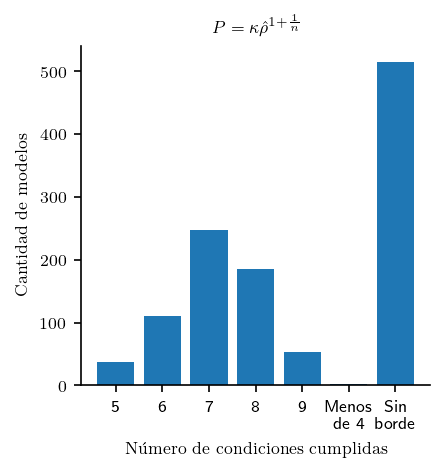

In [9]:
ListaFlat = [x for L1 in ListaModelos for L2 in L1 for L3 in L2 for x in L3[0]]

Y = [ListaFlat.count('white'),ListaFlat.count('purple'),ListaFlat.count('darkorange'),ListaFlat.count('green'),
     ListaFlat.count('blue'),ListaFlat.count('red'),ListaFlat.count('gray')]
X = ['Menos \n de 4','5','6','7','8','9','Sin \n borde']

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(3,3),dpi=150)
fig = plt.figure(figsize=(6,9),dpi=150)

ax1.bar(X,Y)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.set_xlabel(r'$\textrm{N\'umero\ de\ condiciones\ cumplidas}$',fontsize=8,labelpad=5.0)
ax1.set_ylabel(r'$\textrm{Cantidad de modelos}$',fontsize=8,labelpad=5.0,rotation=90)
ax1.set_title(r'$P = \kappa \hat{\rho}^{1+\frac{1}{n}}$',fontsize=8)

plt.show()